# Install packages

In [ ]:
# had to use pip since it wasn't available with mamba
%pip install duckduckgo_search

In [ ]:
%mamba install fastai

## Step 1: Download images of birds and non-birds

In [1]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(DDGS().images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [2]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


'https://images.pexels.com/photos/1661179/pexels-photo-1661179.jpeg?cs=srgb&dl=green-bird-1661179.jpg&fm=jpg'

...and then download a URL and take a look at it:

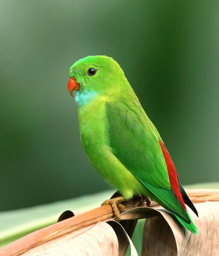

In [6]:
from fastdownload import download_url
from fastai.vision.all import Image
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=True)

im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

Searching for 'forest photos'


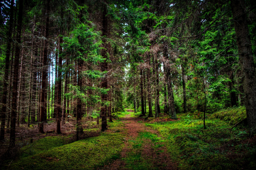

In [7]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=True)
Image.open('forest.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [8]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep
from fastai.vision.all import download_images, resize_images

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'
